In [1]:
import riiideducation
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
env = riiideducation.make_env()

In [2]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                   usecols = [1,2,3,4,7,8,9],
                   dtype={'timestamp':'int64',
                         'used_id':'int32',
                         'content_id':'int16',
                         'content_type_id':'int8',
                         'answered_correctly':'int8',
                         'prior_question_elapsed_time':'float32',
                         'prior_question_had_explanation':'boolean'})

In [3]:
train = train[train.content_type_id == False]

train = train.sort_values(['timestamp'],ascending=True).reset_index(drop=True)
train.head(10)

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,NaN,<NA>
1,0,1805962620,5547,0,0,NaN,<NA>
2,0,2015251289,4024,0,1,NaN,<NA>
3,0,867941388,6659,0,1,NaN,<NA>
4,0,867946278,3977,0,1,NaN,<NA>
5,0,867947333,7900,0,1,NaN,<NA>
6,0,1440786713,3889,0,1,NaN,<NA>
7,0,1805972720,5796,0,0,NaN,<NA>
8,0,579725075,7900,0,1,NaN,<NA>
9,0,390617956,4867,0,1,NaN,<NA>


In [4]:
result_c_final = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
result_c_final.head(10)


,answered_correctly
,mean
content_id,
0,0.907721
1,0.890646
2,0.554281
3,0.779437
4,0.613215
5,0.861828
6,0.474545
7,0.866024


In [5]:
result_c_final.columns = ['answered_correctly_content']
result_c_final.head(10)

,answered_correctly_content
content_id,
0,0.907721
1,0.890646
2,0.554281
3,0.779437
4,0.613215
5,0.861828
6,0.474545
7,0.866024
8,0.906620


In [6]:
result_u_final = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean','sum','count'])
result_u_final.columns = ['answered_correctly_user','sum','count']
result_u_final.head(10)

,answered_correctly_user,sum,count
user_id,,,
115,0.695652,32.0,46
124,0.233333,7.0,30
2746,0.578947,11.0,19
5382,0.672000,84.0,125
8623,0.642202,70.0,109
8701,0.588235,10.0,17
12741,0.573585,152.0,265
13134,0.706356,878.0,1243
24418,0.690275,4337.0,6283


In [7]:
elapsed_mean = train.prior_question_elapsed_time.mean()

In [8]:
elapsed_mean

13238.587890625

In [9]:
train.loc[(train.timestamp == 0)].answered_correctly.mean()

0.6787809364253148

In [10]:
train.loc[(train.timestamp != 0)].answered_correctly.mean()

0.6571491814363561

In [11]:
train.loc[(train.timestamp < 1000000) & (train.timestamp > 0)].answered_correctly.mean()

0.4760203372564661

In [12]:
train.prior_question_had_explanation.value_counts()

True     89685560
False     9193234
Name: prior_question_had_explanation, dtype: Int64

In [13]:
train.answered_correctly.mean()

0.6572355454194717

In [14]:
train.drop(['timestamp','content_type_id'], axis=1, inplace=True)
# 删除timestamp和content_type_id这两列

# 创建验证集

In [15]:
valid = pd.DataFrame()

In [16]:
for i in range(4):
    last_records = train.drop_duplicates('user_id',keep='last')
    # 按照user_id那列的内容删除重复列，并且保存最后一个元素，也就是取每个user的最后时刻的做题记录
    train = train[~train.index.isin(last_records.index)]
    # train.index.isin(last_recoreds.index)就是去train中检索当前index是否在last_records.index里面
    # 如果在返回true，如果不在返回false。但是前面还有个~，所以进行了反向索引。
    # 也就是最后留下的train里面不包含last_records的内容
    valid = valid.append(last_records)
    # 迭代了4次，也就是说最后valid里面存储了每个用户的最后4条做题记录


In [17]:
len(train)


97697098

In [18]:
train.head(10)

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,<NA>
1,1805962620,5547,0,NaN,<NA>
2,2015251289,4024,1,NaN,<NA>
3,867941388,6659,1,NaN,<NA>
4,867946278,3977,1,NaN,<NA>
5,867947333,7900,1,NaN,<NA>
6,1440786713,3889,1,NaN,<NA>
7,1805972720,5796,0,NaN,<NA>
8,579725075,7900,1,NaN,<NA>
9,390617956,4867,1,NaN,<NA>


In [19]:
len(valid)

1574202

In [20]:
valid.answered_correctly.mean()

0.5335192052862339

In [21]:
train.answered_correctly.mean()

0.6592289977743249

# 构建训练数据

In [22]:
x = pd.DataFrame()

In [23]:
for i in range(15):
    last_records = train.drop_duplicates('user_id',keep='last')
    train = train[~train.index.isin(last_records.index)]
    x = x.append(last_records)
    

In [24]:
len(x)

5688652

In [25]:
len(train)

92008446

In [26]:
x.answered_correctly.mean()

0.5565163768147533

In [27]:
train.answered_correctly.mean()

0.6655794621289441

# 合成数据

In [28]:
results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])

In [29]:
results_c.columns = ["answered_correctly_content"]

In [30]:
results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean','sum','count'])

In [31]:
results_u.columns = ["answered_correctly_user","sum","count"]

In [32]:
del(train)

In [33]:
x.head(10)

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
18701,888540983,6269,1,NaN,<NA>
20413,1418755930,5314,1,NaN,<NA>
21067,2004252207,128,1,NaN,<NA>
31307,825864574,8440,1,NaN,<NA>
36833,1646232520,4357,1,NaN,<NA>
112442,938282142,3623,0,NaN,<NA>
173745,466117571,5958,0,NaN,<NA>
178181,659362682,5118,0,NaN,<NA>
211578,1639083714,5970,0,NaN,<NA>
211823,790143287,5007,0,NaN,<NA>


In [34]:
results_u.head(10)

,answered_correctly_user,sum,count
user_id,,,
115,0.703704,19.0,27
124,0.272727,3.0,11
5382,0.669811,71.0,106
8623,0.611111,55.0,90
12741,0.556911,137.0,246
13134,0.709150,868.0,1224
24418,0.690294,4324.0,6264
24600,0.225806,7.0,31
32421,0.545455,6.0,11


In [35]:
x = pd.merge(x, results_u, on=['user_id'], how='left')
x = pd.merge(x, result_c_final, on=['content_id'],how='left')
# 这里是把当前训练集和user的做题准确率等和题目总体的准确率等信息合并起来，
# 这里的user的做题信息，采取的是用户除了这15个最近的做题日之外的做题的准确率
# 而题目的准确率信息则是全局整体的做题记录分析出的
x.head(10)

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content
0,888540983,6269,1,NaN,<NA>,NaN,NaN,NaN,0.821711
1,1418755930,5314,1,NaN,<NA>,NaN,NaN,NaN,0.783144
2,2004252207,128,1,NaN,<NA>,NaN,NaN,NaN,0.966869
3,825864574,8440,1,NaN,<NA>,NaN,NaN,NaN,0.953749
4,1646232520,4357,1,NaN,<NA>,NaN,NaN,NaN,0.764535
5,938282142,3623,0,NaN,<NA>,NaN,NaN,NaN,0.502464
6,466117571,5958,0,NaN,<NA>,NaN,NaN,NaN,0.459773
7,659362682,5118,0,NaN,<NA>,NaN,NaN,NaN,0.730798
8,1639083714,5970,0,NaN,<NA>,NaN,NaN,NaN,0.427269
9,790143287,5007,0,NaN,<NA>,NaN,NaN,NaN,0.688170


In [36]:
valid = pd.merge(valid, results_u, on=['user_id'],how='left')
valid = pd.merge(valid, result_c_final, on=['content_id'], how='left')

# 数据预处理

In [37]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

x.prior_question_had_explanation.fillna(False, inplace=True)
valid.prior_question_had_explanation.fillna(False, inplace=True)

valid["prior_question_had_explanation_enc"] = lb_make.fit_transform(valid["prior_question_had_explanation"])
x["prior_question_had_explanation_enc"] = lb_make.fit_transform(x["prior_question_had_explanation"])
# LabelEncoder.fit_transform()相当于将其他的不适合模型训练的值，比如布尔值，种类类别如cat,dog等，
# 转换成对应的0~num_class-1的数值，方便进行模型训练

In [38]:
x.head(100)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc
0,888540983,6269,1,NaN,False,NaN,NaN,NaN,0.821711,0
1,1418755930,5314,1,NaN,False,NaN,NaN,NaN,0.783144,0
2,2004252207,128,1,NaN,False,NaN,NaN,NaN,0.966869,0
3,825864574,8440,1,NaN,False,NaN,NaN,NaN,0.953749,0
4,1646232520,4357,1,NaN,False,NaN,NaN,NaN,0.764535,0
...,...,...,...,...,...,...,...,...,...,...
95,528969551,11535,1,13000.0,False,NaN,NaN,NaN,0.368267,0
96,30683589,5976,0,9000.0,False,NaN,NaN,NaN,0.431772,0
97,619663752,6266,0,18000.0,False,NaN,NaN,NaN,0.514274,0
98,1762919069,5190,1,13000.0,False,NaN,NaN,NaN,0.712399,0


# 读取question.csv

In [39]:
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                          usecols=[0,3],
                          dtype={'question_id':'int16',
                                'part':'int8'})

In [40]:
questions_df.head(10)

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


In [41]:
x.head(10)

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc
0,888540983,6269,1,NaN,False,NaN,NaN,NaN,0.821711,0
1,1418755930,5314,1,NaN,False,NaN,NaN,NaN,0.783144,0
2,2004252207,128,1,NaN,False,NaN,NaN,NaN,0.966869,0
3,825864574,8440,1,NaN,False,NaN,NaN,NaN,0.953749,0
4,1646232520,4357,1,NaN,False,NaN,NaN,NaN,0.764535,0
5,938282142,3623,0,NaN,False,NaN,NaN,NaN,0.502464,0
6,466117571,5958,0,NaN,False,NaN,NaN,NaN,0.459773,0
7,659362682,5118,0,NaN,False,NaN,NaN,NaN,0.730798,0
8,1639083714,5970,0,NaN,False,NaN,NaN,NaN,0.427269,0
9,790143287,5007,0,NaN,False,NaN,NaN,NaN,0.688170,0


In [42]:
x = pd.merge(x, questions_df, left_on='content_id',right_on='question_id',how='left')

In [43]:
x.head(10)

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc,question_id,part
0,888540983,6269,1,NaN,False,NaN,NaN,NaN,0.821711,0,6269,5
1,1418755930,5314,1,NaN,False,NaN,NaN,NaN,0.783144,0,5314,5
2,2004252207,128,1,NaN,False,NaN,NaN,NaN,0.966869,0,128,1
3,825864574,8440,1,NaN,False,NaN,NaN,NaN,0.953749,0,8440,5
4,1646232520,4357,1,NaN,False,NaN,NaN,NaN,0.764535,0,4357,5
5,938282142,3623,0,NaN,False,NaN,NaN,NaN,0.502464,0,3623,5
6,466117571,5958,0,NaN,False,NaN,NaN,NaN,0.459773,0,5958,5
7,659362682,5118,0,NaN,False,NaN,NaN,NaN,0.730798,0,5118,5
8,1639083714,5970,0,NaN,False,NaN,NaN,NaN,0.427269,0,5970,5
9,790143287,5007,0,NaN,False,NaN,NaN,NaN,0.688170,0,5007,5


In [44]:
valid = pd.merge(valid, questions_df, left_on='content_id',right_on='question_id',how='left')

In [45]:
x.part = x.part-1
valid.part = valid.part - 1
# 让part值的起始值为0

x.part.value_counts()

4    2949470
1    1154514
5     519617
3     454899
0     274922
6     178413
2     156817
Name: part, dtype: int64

In [46]:
y = x['answered_correctly']
x = x.drop(['answered_correctly'],axis=1)
x.head(10)

,user_id,content_id,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc,question_id,part
0,888540983,6269,NaN,False,NaN,NaN,NaN,0.821711,0,6269,4
1,1418755930,5314,NaN,False,NaN,NaN,NaN,0.783144,0,5314,4
2,2004252207,128,NaN,False,NaN,NaN,NaN,0.966869,0,128,0
3,825864574,8440,NaN,False,NaN,NaN,NaN,0.953749,0,8440,4
4,1646232520,4357,NaN,False,NaN,NaN,NaN,0.764535,0,4357,4
5,938282142,3623,NaN,False,NaN,NaN,NaN,0.502464,0,3623,4
6,466117571,5958,NaN,False,NaN,NaN,NaN,0.459773,0,5958,4
7,659362682,5118,NaN,False,NaN,NaN,NaN,0.730798,0,5118,4
8,1639083714,5970,NaN,False,NaN,NaN,NaN,0.427269,0,5970,4
9,790143287,5007,NaN,False,NaN,NaN,NaN,0.688170,0,5007,4


In [47]:
y_val = valid['answered_correctly']
x_val = valid.drop(['answered_correctly'],axis=1)

In [48]:
x = x[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]
x_val = x_val[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]

In [49]:
x['answered_correctly_user'].fillna(0.5, inplace=True)
x['answered_correctly_content'].fillna(0.5, inplace=True)

x['part'].fillna(4,inplace=True)
x['sum'].fillna(0,inplace=True)
x['count'].fillna(0, inplace=True)
x['prior_question_elapsed_time'].fillna(elapsed_mean, inplace=True)
x['prior_question_had_explanation_enc'].fillna(0, inplace=True)


In [50]:
x_val['answered_correctly_user'].fillna(0.5,  inplace=True)
x_val['answered_correctly_content'].fillna(0.5,  inplace=True)

x_val['part'].fillna(4, inplace = True)
x_val['count'].fillna(0, inplace = True)
x_val['sum'].fillna(0, inplace = True)
x_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
x_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

# 模型训练

In [51]:
import lightgbm as lgb

params = {
    'objective':'binary',
    'max_bin':700,
    'learning_rate':0.0175,
    'num_leaves':80
}

In [52]:
lgb_train = lgb.Dataset(x,y, categorical_feature=['part','prior_question_had_explanation_enc'])
lgb_eval = lgb.Dataset(x_val, y_val, categorical_feature=['part','prior_question_had_explanation_enc'],
                      reference=lgb_train)

In [53]:
model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=50,
        num_boost_round=10000,
        early_stopping_rounds=12
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 12 rounds
[50]	training's binary_logloss: 0.613885	valid_1's binary_logloss: 0.630455
[100]	training's binary_logloss: 0.597501	valid_1's binary_logloss: 0.617506
[150]	training's binary_logloss: 0.593094	valid_1's binary_logloss: 0.614234
[200]	training's binary_logloss: 0.591459	valid_1's binary_logloss: 0.612883
[250]	training's binary_logloss: 0.590664	valid_1's binary_logloss: 0.612151
[300]	training's binary_logloss: 0.590152	valid_1's binary_logloss: 0.611606
[350]	training's binary_logloss: 0.589803	valid_1's binary_logloss: 0.611247
[400]	training's binary_logloss: 0.58954	valid_1's binary_logloss: 0.61108
[450]	training's binary_logloss: 0.589368	valid_1's binary_logloss: 0.610988
[500]	training's binary_logloss: 0.589226	valid_1's binary_logloss: 0.610898
[550]	training's binary_logloss: 0.589091	valid_1's binary_logloss: 0.610829
[600]	training's binary_logloss: 0.58898	valid_1's binary_logloss: 0.610781
[650]	training's bi

In [54]:
y_pred = model.predict(x_val)
y_true = np.array(y_val)
roc_auc_score(y_true, y_pred)

0.7260482266520388

# 查看哪些feature最重要

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

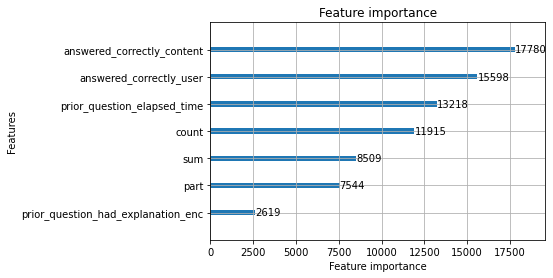

In [56]:
lgb.plot_importance(model)
plt.show()

# 对于测试数据做预测

In [57]:
iter_test = env.iter_test()

In [58]:

for(test_df, sample_prediction_df) in iter_test:
    test_df = pd.merge(test_df, questions_df, left_on='content_id',
                       right_on='question_id',how='left')
    test_df = pd.merge(test_df, result_u_final, on=['user_id'],how='left')
    test_df = pd.merge(test_df, result_c_final, on=['content_id'],how='left')
    test_df['answered_correctly_user'].fillna(0.5, inplace=True)
    test_df['answered_correctly_content'].fillna(0.5, inplace=True)
    test_df['part'] = test_df.part-1
    
    test_df['part'].fillna(4, inplace=True)
    test_df['sum'].fillna(0,inplace=True)
    test_df['count'].fillna(0,inplace=True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
                                                                  'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']])
   
    
    env.predict(test_df.loc[test_df['content_type_id']==0, ['row_id','answered_correctly']])
    
    